# Propensity Score Matching

Author: Olatomiwa Bifarin<br>
Department of Biochemistry and Molecular Biology<br>
University of Georgia<br>
Edison Lab<br>

Last edited: 28JAN2020 

_This is a static version of a Jupyter notebook, and work (documentation) is still in progress_ 

**Goals**: 
1. Propensity Score Matching
2. Define Model Cohort
3. Define the Test Cohort

<a id="0"></a>

## Notebook Content

1.  [Propensity Matching: Model Cohort](#1)
2.  [Cohort Characteristics: Post-Matched Group (Model Cohort)](#2)



## Dataframes
-  `combined` is the NMR merged with the MS dataset. 
-  `combined_clinic` is the dataframe that contains all combined NMR and MS samples collected in the clinic. 
-  `PMdata`
-  `PMdata2`
-  `modelcohort`
-  `testcohort`

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import style
import scipy
#For Seaborn plots
import seaborn as sns; sns.set(style='white')
#To ignore warning
import warnings
warnings.filterwarnings('ignore')

# More sharp and legible graphics
%config InlineBackend.figure_format = 'retina'

# Set seaborn figure labels to 'talk', to be more visible. 
sns.set_context('talk', font_scale=0.8)

# 1. Propensity Score Matching: Model Cohort
<a id="1"></a>

**Goal**: To match healthy controls to RCC (treatments) based on age, gender, BMI, race and smoking history; optimizing for these five, using propensity score matching. 

__Code Reference:__  <br> 
Complete: https://nbviewer.jupyter.org/github/kellieotto/StatMoments/blob/master/PSM_complete.ipynb <br>
Incomplete: https://nbviewer.jupyter.org/github/kellieotto/StatMoments/blob/master/PSM.ipynb

In [4]:
import math
from scipy.stats import binom, hypergeom
from sklearn.linear_model import LogisticRegression
import sklearn

In [5]:
print(sklearn.__version__)

0.21.2


### a. Data Prep

In [64]:
combined_clinic = pd.read_excel('data/combined_clinic.xlsx')

In [65]:
PMdata = combined_clinic.filter(["Patient ID", "Gender", "BMI", "Smoker", 
                                 "Age", "Race", "Groups"])
PMdata.head()

,Patient ID,Gender,BMI,Smoker,Age,Race,Groups
0,PD001,Male,24.4,Never,38.1,White,RCC
2,PD005,Male,34.2,Never,64.0,White,RCC
8,PD030,Female,23.9,Never,74.5,White,RCC
13,PD040,Female,32.5,Former/Current,35.1,White,RCC
14,PD045,Female,24.9,Never,56.0,Black/AA,RCC


_Map Strings to Numericals_

In [66]:
d = {'Male': 0, 'Female': 1}
PMdata['Gender'] = PMdata['Gender'].map(d)
d = {'Never': 0, 'Former/Current': 1} #classify former and current smoker as one group
PMdata['Smoker'] = PMdata['Smoker'].map(d)
d = {'Control': 0, 'RCC': 1}
PMdata['Groups'] = PMdata['Groups'].map(d)
d = {'White': 0, 'Black/AA': 1, 'Others': 2 } #classify Unk/Missing, Asian, and Mixed as Others
PMdata['Race'] = PMdata['Race'].map(d)

### b. Compute Propensity Score

In [67]:
names = ['Gender', 'BMI', 'Smoker', 'Age', 'Race', 'Groups', 'Patient ID']
names[:5]

['Gender', 'BMI', 'Smoker', 'Age', 'Race']

In [68]:
propensity = LogisticRegression(random_state=42)
propensity = propensity.fit(PMdata[names[:5]], PMdata.Groups)
pscore = propensity.predict_proba(PMdata[names[:5]])[:,1] # The predicted propensities by the model
print (pscore[:5])

PMdata['Propensity'] = pscore

[0.09091652 0.09039211 0.28361565 0.34253826 0.42695976]


### c. Matching

In [69]:
def MatchMany(groups, propensity, method = "caliper", k = 1, 
              caliper = 0.01, caliper_method = "propensity", replace = True):
    ''' 
    Implements greedy one-to-many matching on propensity scores.
    
    Inputs:
    groups = Array-like object of treatment assignments.  Must be 2 groups
    propensity = Array-like object containing propensity scores for each observation. Propensity and groups should be in the same order (matching indices)
    method = a string: "caliper" (default) to select all matches within a given range, "knn" for k nearest neighbors,
    k = an integer (default is 1). If method is "knn", this specifies the k in k nearest neighbors
    caliper = a numeric value, specifies maximum distance (difference in propensity scores or SD of logit propensity) 
    caliper_method = a string: "propensity" (default) if caliper is a maximum difference in propensity scores,
            "logit" if caliper is a maximum SD of logit propensity, or "none" for no caliper
    replace = Logical for whether individuals from the larger group should be allowed to match multiple individuals in the smaller group.
        (default is True)
    
    Output:
    A series containing the individuals in the control group matched to the treatment group.
    Note that with caliper matching, not every treated individual may have a match within calipers.
        In that case we match it to its single nearest neighbor.  The alternative is to throw out individuals with no matches, but then we'd no longer be estimating the ATT.
    '''

    # Check inputs
    if any(propensity <=0) or any(propensity >=1):
        raise ValueError('Propensity scores must be between 0 and 1')
    elif not(0<=caliper<1):
        if caliper_method == "propensity" and caliper>1:
            raise ValueError('Caliper for "propensity" method must be between 0 and 1')
        elif caliper<0:
            raise ValueError('Caliper cannot be negative')
    elif len(groups)!= len(propensity):
        raise ValueError('groups and propensity scores must be same dimension')
    elif len(groups.unique()) != 2:
        raise ValueError('wrong number of groups: expected 2')
        
    
    # Transform the propensity scores and caliper when caliper_method is "logit" or "none"
    if method == "caliper":
        if caliper_method == "logit":
            propensity = log(propensity/(1-propensity))
            caliper = caliper*np.std(propensity)
        elif caliper_method == "none":
            caliper = 0
    
    # Code groups as 0 and 1
    groups = groups == groups.unique()[0]
    N = len(groups)
    N1 = groups[groups == 1].index; N2 = groups[groups == 0].index
    g1, g2 = propensity[groups == 1], propensity[groups == 0]
    # Check if treatment groups got flipped - the smaller should correspond to N1/g1
    if len(N1) > len(N2):
       N1, N2, g1, g2 = N2, N1, g2, g1
        
        
    # Randomly permute the smaller group to get order for matching
    morder = np.random.permutation(N1)
    matches = {}
    
    for m in morder:
        dist = abs(g1[m] - g2)
        dist.sort_values()
        if method == "knn":
            caliper = dist.iloc[k-1]
        # PROBLEM: when there are ties in the knn. 
        # Need to randomly select among the observations tied for the farthest eacceptable distance
        keep = np.array(dist[dist<=caliper].index)
        if len(keep) >= 1:
            matches[m] = keep
        else:
            matches[m] = [dist.argmin()]
        if not replace:
            g2 = g2.drop(matches[m])
    return (matches)

In [70]:
RCCmatch = MatchMany(PMdata.Groups, PMdata.Propensity, method = "caliper",
          caliper = 0.00001, caliper_method = "propensity", replace=False)

In [71]:
RCCmatch

{50: [216],
 52: [200],
 19: [129],
 29: [182],
 2: [236],
 14: [195],
 51: [157],
 49: [99],
 78: [197],
 17: [177],
 30: [113],
 77: [148],
 33: [183],
 23: [116],
 53: [174],
 35: [90],
 48: [101],
 44: [109],
 0: array([187]),
 36: [118],
 22: [83],
 15: [110],
 81: [210],
 13: [239],
 79: [253],
 55: [193],
 21: [247],
 8: [161],
 54: [155],
 80: [222],
 40: [137]}

_Which Samples Matched_

In [72]:
def whichMatched(matches, data, many = False, unique = False):
    ''' 
    Simple function to convert output of Matches to DataFrame of all matched observations
    Inputs:
    matches = output of Match
    data = DataFrame of covariates
    many = Boolean indicating if matching method is one-to-one or one-to-many
    unique = Boolean indicating if duplicated individuals (ie controls matched to more than one case) should be removed
    '''

    tr = matches.keys()
    if many:
        ctrl = [m for matchset in matches.values() for m in matchset]
    else:
        ctrl = matches.values()
        ctrl= [item for sublist in ctrl for item in sublist] # Bif's addition
    # need to remove duplicate rows, which may occur in matching with replacement
    temp = pd.concat([data.ix[tr], data.ix[ctrl]])
    if unique == True:
        return temp.groupby(temp.index).first()
    else:
        return temp

In [73]:
names

['Gender', 'BMI', 'Smoker', 'Age', 'Race', 'Groups', 'Patient ID']

In [74]:
covariates = PMdata[names[:7]]

In [75]:
df_final = whichMatched(RCCmatch, covariates)
df_final.head()

,Gender,BMI,Smoker,Age,Race,Groups,Patient ID
50,1,21.1,0,47.2,0,1,PD120
52,0,25.7,0,61.9,0,1,PD124
19,0,36.4,0,52.8,0,1,PD053
29,0,31.0,0,55.6,1,1,PD088
2,0,34.2,0,64.0,0,1,PD005


In [76]:
print(len(df_final))
print (df_final.Groups.value_counts())

62
1    31
0    31
Name: Groups, dtype: int64


### d. Balance Diagnostics

In [77]:
def Balance(groups, covariates):
    '''
    Computes absolute difference of means and standard error for covariates by group
    '''
    means = covariates.groupby(groups).mean()
    dist = abs(means.diff()).ix[1]
    std = covariates.groupby(groups).std()
    #n = groups.value_counts()
    #se = std.apply(lambda(s): np.sqrt(s[0]**2/n[0] + s[1]**2/n[1]))
    return dist, std

In [78]:
Balance(PMdata.Groups, PMdata[names[:4]])

(Gender    0.381720
 BMI       1.782314
 Smoker    0.139970
 Age       5.054950
 Name: 1, dtype: float64,           Gender       BMI    Smoker        Age
 Groups                                         
 0       0.373754  4.521163  0.432586  10.325633
 1       0.505879  5.800341  0.495138  12.089623)

In [79]:
def plotScores(groups, propensity, matches, many=True):
    '''
    Plot density of propensity scores for each group before and after matching
    
    Inputs: groups = treatment assignment, pre-matching
            propensity = propensity scores, pre-matching
            matches = output of Match or MatchMany
            many = indicator - True if one-many matching was done (default is True), otherwise False
    '''
    pre = pd.DataFrame({'groups':groups, 'propensity':propensity})    
    post = whichMatched(matches, pre, many = many, unique = False)
    
    plt.figure(1)
    plt.subplot(121)
    density0 = scipy.stats.gaussian_kde(pre.propensity[pre.groups==0])
    density1 = scipy.stats.gaussian_kde(pre.propensity[pre.groups==1])
    xs = np.linspace(0,1,1000)
    #density0.covariance_factor = lambda : 0.5
    #density0._compute_covariance()
    #density1.covariance_factor = lambda : 0.5
    #density1._compute_covariance()
    plt.plot(xs,density0(xs),color='black')
    plt.fill_between(xs,density1(xs),color='gray')
    plt.title('Before Matching')
    plt.xlabel('Propensity Score')
    plt.ylabel('Density')
    
    plt.subplot(122)
    density0_post = scipy.stats.gaussian_kde(post.propensity[post.groups==0])
    density1_post = scipy.stats.gaussian_kde(post.propensity[post.groups==1])
    xs = np.linspace(0,1,1000)
    #density0.covariance_factor = lambda : 0.5
    #density0._compute_covariance()
    #density1.covariance_factor = lambda : 0.5
    #density1._compute_covariance()
    plt.plot(xs,density0_post(xs),color='black')
    plt.fill_between(xs,density1_post(xs),color='gray')
    plt.title('After Matching')
    plt.xlabel('Propensity Score')
    plt.ylabel('Density')
    plt.show()

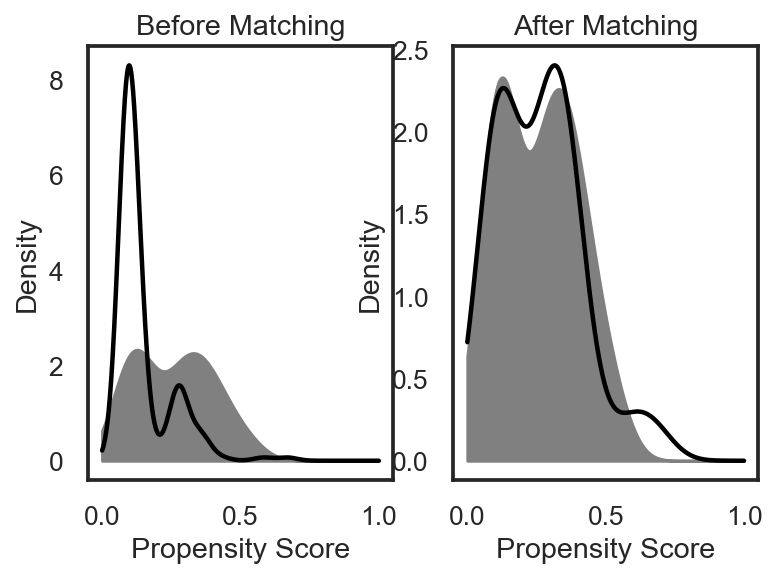

In [80]:
plotScores(PMdata.Groups, PMdata.Propensity, RCCmatch)

In [81]:
df_final.columns

Index(['Gender', 'BMI', 'Smoker', 'Age', 'Race', 'Groups', 'Patient ID'], dtype='object')

### [Go back to notebook content](#0)

# 2. Cohort Characteristics: Post-Matched Groups
<a id="2"></a>

In [82]:
combined = pd.read_excel('data/combined.xlsx')

In [83]:
dfsample = df_final['Patient ID']

In [84]:
data = pd.merge(dfsample.to_frame(), combined, on='Patient ID') 
#Only select data for the PS-Matched cohort. 

In [85]:
data.shape

(62, 7154)

### (a) Quantitative Meta Data

_Function for Quantitative Cohort Characteristics_

In [86]:
def cohortQuant(cohortID, dfControl, dfTreat, alpha=0.05, var=True):
    '''
    Function conducts a T-test for the numerical cohort characteristics between two groups
    
    Inputs: 
    cohortID = A list of the numerical cohort characteristics
    dfControl = A pandas dataframe containing the control group cohort data
    dfTreat =  A pandas dataframe containing the treatment group cohort data
    alpha = alpha for statistical significant judgment, Default 0.05
    var = If True (default), perform a standard independent 2 sample test that assumes 
    equal population variances [1]. If False, perform Welch’s t-test, which does not 
    assume equal population variance
    
    Outputs: A pandas dataframe with p-values of numerical cohort characteristics. 
    
    '''
    pvaluelist = []
    commentlist = []
    for conf in cohortID:
        statistic, pvalue = scipy.stats.ttest_ind(dfControl[conf], dfTreat[conf], 
                                              equal_var=var)
        pvaluelist.append(pvalue)
        if pvalue > alpha:
            comment = 'not significant'
        else:
            comment = 'significant'
        commentlist.append(comment)
    ConfTable = pd.DataFrame({'Confounder': cohortID, 
                              'T-test p-value': pvaluelist, 
                              'Comment': commentlist})
    return ConfTable
    

In [87]:
data.Groups.value_counts()

Control    31
RCC        31
Name: Groups, dtype: int64

In [88]:
confounderID = ['Age', 'BMI']
dControl = data[(data['Groups'] == 'Control')]
dRCC = data[(data['Groups'] == 'RCC')]
cohortQuant(confounderID, dControl, dRCC, var=True)

,Confounder,T-test p-value,Comment
0,Age,0.639379,not significant
1,BMI,0.059494,not significant


In [89]:
print('CONTROL', dControl.filter(['Age', 'BMI'], axis=1).describe())
print('RCC', dRCC.filter(['Age', 'BMI'], axis=1).describe())

CONTROL              Age        BMI
count  31.000000  31.000000
mean   58.000000  26.493548
std    13.025616   4.869492
min    26.000000  17.500000
25%    50.000000  23.100000
50%    57.000000  25.500000
75%    66.000000  30.650000
max    85.000000  35.400000
RCC              Age        BMI
count  31.000000  31.000000
mean   59.503226  29.106452
std    12.089623   5.800341
min    32.600000  17.400000
25%    55.600000  24.900000
50%    60.200000  29.400000
75%    66.800000  33.050000
max    77.100000  42.100000


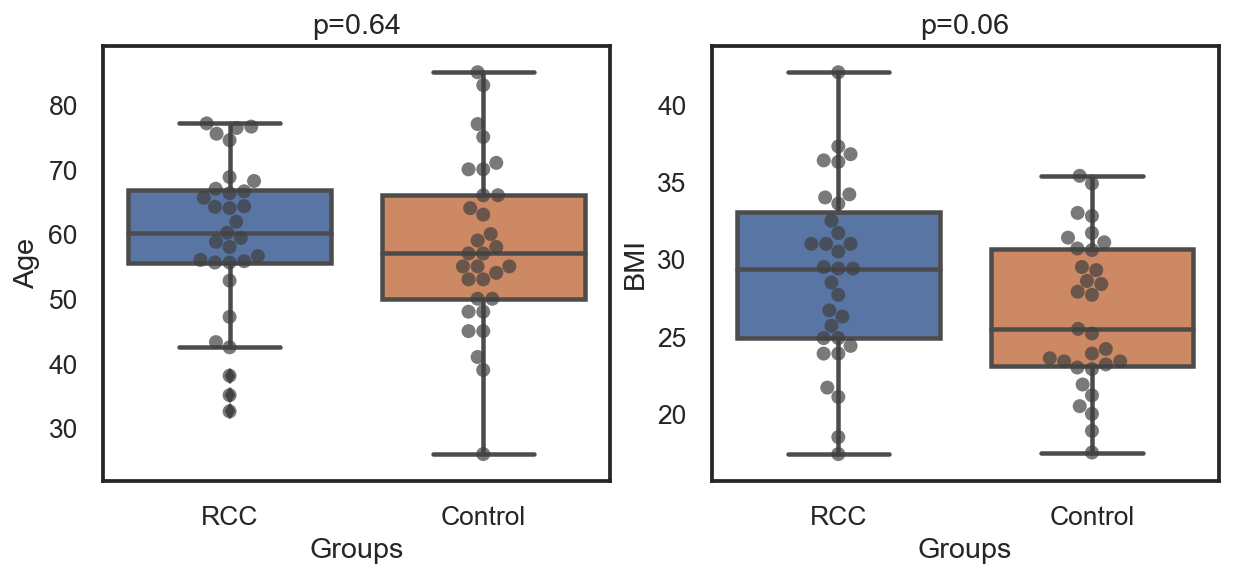

In [90]:
_, axes = plt.subplots(1, 2, sharey=False, figsize=(10, 4))

Age = sns.boxplot(x='Groups', y='Age', data=data, ax=axes[0]);
sns.swarmplot(x='Groups', y='Age', data=data, s =7, alpha=0.7, color=".25", ax=axes[0])
BMI = sns.boxplot(x='Groups', y='BMI', data=data, ax=axes[1]);
sns.swarmplot(x='Groups', y='BMI', data=data, s =7, alpha=0.7, color=".25", ax=axes[1])
Age.set_title('p=0.64',loc='center');
BMI.set_title('p=0.06',loc='center');
#plt.savefig('postmatch_Age_BMI.svg') 

### (b) Categorical Meta Data

In [91]:
# Recall that Former and Current were treated as one entity in PS matching. 
data['Smoker'].replace({'Current': 'Former/Current', 'Former': 'Former/Current'}, inplace=True);
data['Race'].replace({'Mixed': 'Others', 'Unk/Missing': 'Others'}, inplace=True);

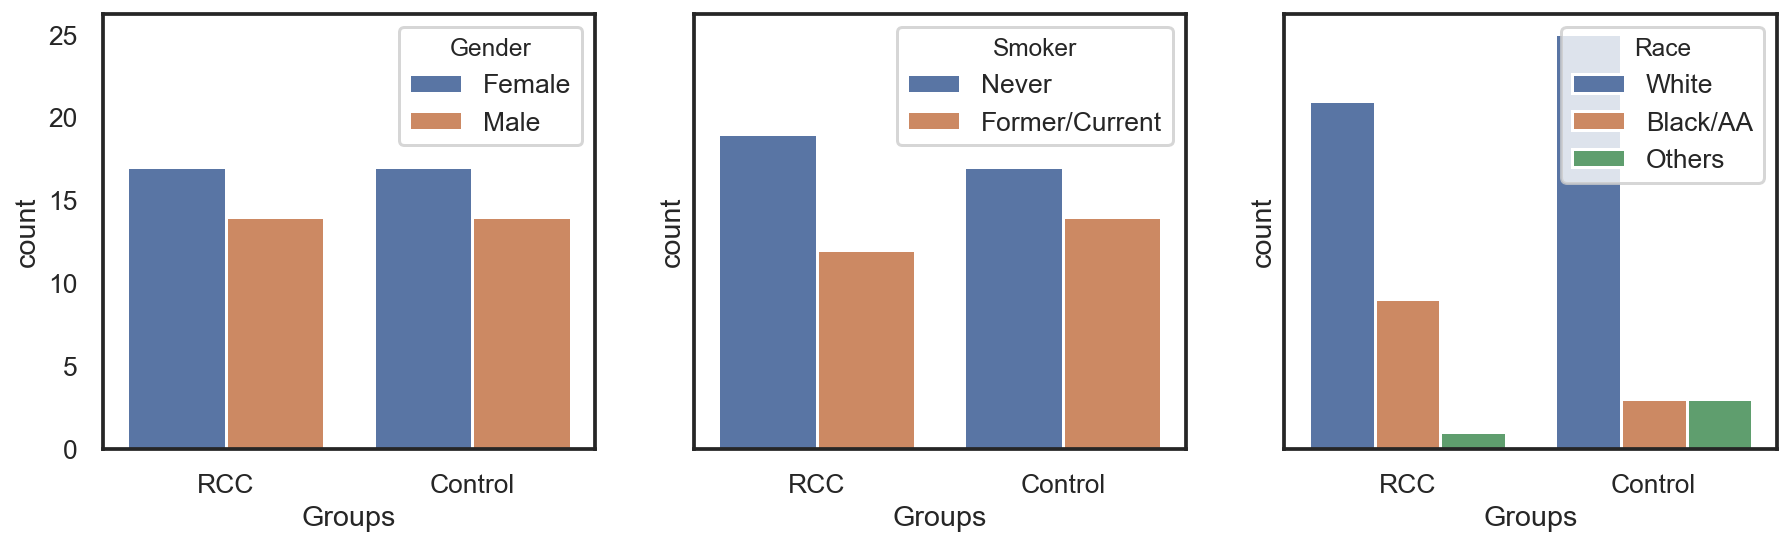

In [92]:
_, axes = plt.subplots(1, 3, sharey=True, figsize=(15, 4))

sns.countplot(x='Groups', hue='Gender', data=data, ax=axes[0]);
sns.countplot(x='Groups', hue='Smoker', data=data, ax=axes[1]);
sns.countplot(x='Groups', hue='Race', data=data, ax=axes[2]);

___Piechart function___

In [93]:
def pieChart(dataframe, tilt_num, explode=False, shadow=False): 
    '''
    DEPENDENCY: matplotlib.pyplot.pie
    
    INPUTS: 
    dataframe = A pandas dataframe with category in the first column and associated data in the second column
    tilt_num = A number that specifies the amount of offset to apply to the wedge corresponding to the dataset 
    on the last row. The purpose of this is to make pie-chart annotation visible in the case of an overlapping 
    annotation. For best results, choose number between 0 and 1.  
    
    explode = Boolean. Set to True to make the tilt_num parameters applicable. 
    
    shadow = Boolean. Set to True for wedge shadows
    
    OUTPUTS: A pie chart figure. 
    
    '''
    if explode==False: 
        plt.pie(
        # using data
        dataframe.iloc[:, 1],
        # labels
        labels=dataframe.iloc[:, 0],
        # with no shadows
        shadow=shadow,
        # with the start angle at 90%
        startangle=90,
        # with the percent listed as a fraction
        autopct='%1.1f%%')
    
        # View the plot drop above
        plt.axis('equal')
        # View the plot
        plt.tight_layout()
        fig = plt.show()
        return fig
    else:
        lst = [0] * dataframe.shape[0] # create a list of length equal to number of pie, sets to zero
        lst[-1] = tilt_num # replace the last digit of lst with the tilt_num
        plt.pie(dataframe.iloc[:, 1], labels=dataframe.iloc[:, 0],
        shadow=shadow, explode=lst, startangle=90, autopct='%1.1f%%')
    
        # View the plot drop above
        plt.axis('equal')
        # View the plot
        plt.tight_layout()
        fig = plt.show()
    return fig

_Gender_

In [94]:
print(dControl['Gender'].value_counts())
print(dControl['Gender'].value_counts(normalize=True)*100)
print(dRCC['Gender'].value_counts())
print(dRCC['Gender'].value_counts(normalize=True)*100)

Female    17
Male      14
Name: Gender, dtype: int64
Female    54.83871
Male      45.16129
Name: Gender, dtype: float64
Female    17
Male      14
Name: Gender, dtype: int64
Female    54.83871
Male      45.16129
Name: Gender, dtype: float64


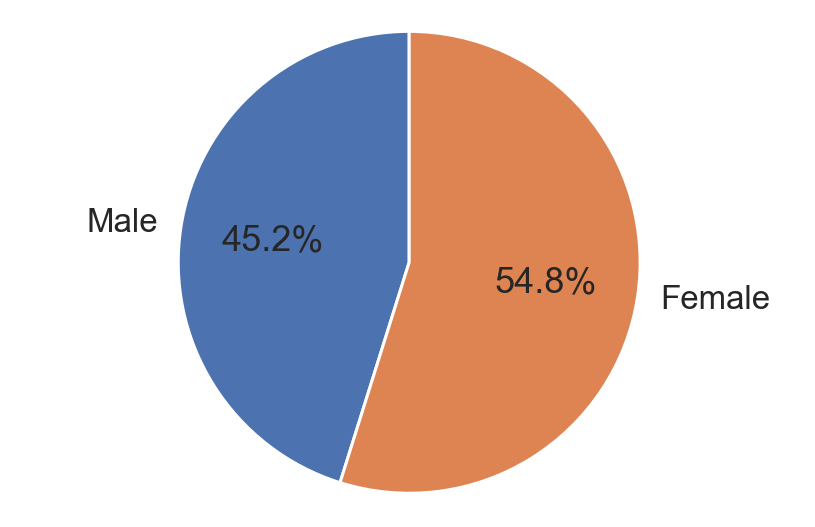

In [95]:
# Set seaborn figure labels to 'talk', to be more visible. 
sns.set_context('talk', font_scale=1.0)
raw_data = {'Gender': ['Male', 'Female'], 'Numbers': [14, 17]}
pie = pd.DataFrame(raw_data)
pieChart(pie, 0.5, explode=False, shadow = False);
#plt.savefig('postmatch_N_Gender.svg') 

_Smoking History_

In [96]:
data.Smoker.value_counts()

Never             36
Former/Current    26
Name: Smoker, dtype: int64

In [97]:
dControl = data[(data['Groups'] == 'Control')]
dRCC = data[(data['Groups'] == 'RCC')]
print(dControl['Smoker'].value_counts())
print(dControl['Smoker'].value_counts(normalize=True)*100)
print(dRCC['Smoker'].value_counts())
print(dRCC['Smoker'].value_counts(normalize=True)*100)

Never             17
Former/Current    14
Name: Smoker, dtype: int64
Never             54.83871
Former/Current    45.16129
Name: Smoker, dtype: float64
Never             19
Former/Current    12
Name: Smoker, dtype: int64
Never             61.290323
Former/Current    38.709677
Name: Smoker, dtype: float64


_Smoking History: Healthy Control_

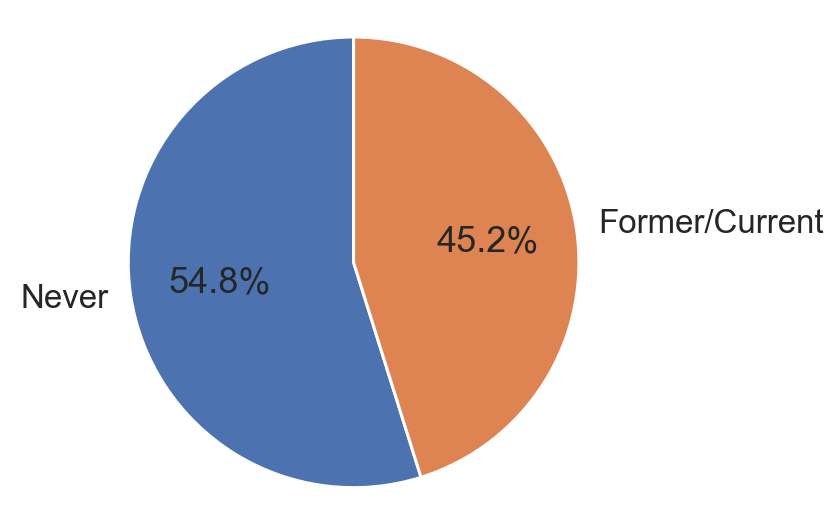

In [98]:
raw_data = {'Smoker': ['Never', 'Former/Current'],
            'Numbers': [17, 14]}
pie = pd.DataFrame(raw_data)
pieChart(pie, 0.5, explode=False, shadow = False)
#plt.savefig('postmatch_N_Smoke.svg') 

_Smoking History: RCC_

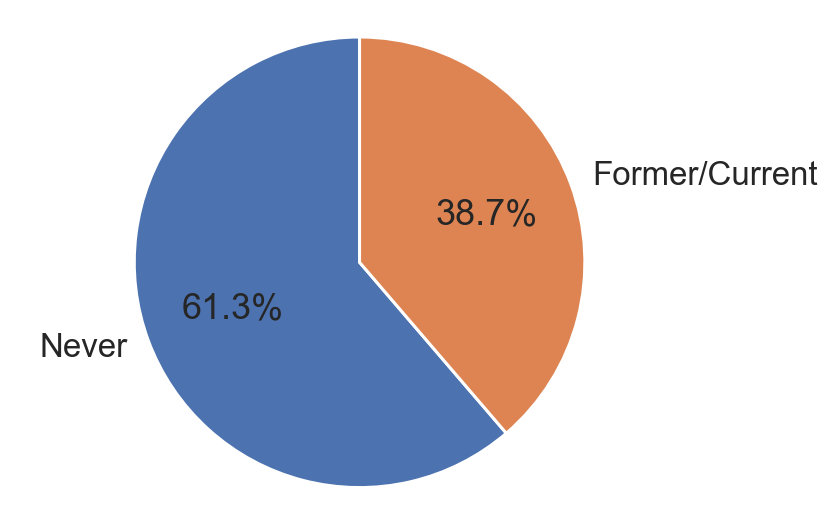

In [99]:
raw_data = {'Smoker': ['Never', 'Former/Current'],
            'Numbers': [19, 12]}
pie = pd.DataFrame(raw_data)
pieChart(pie, 0.5, explode=False, shadow = False)
#plt.savefig('postmatch_C_Smoke.svg') 

_Race_

In [100]:
data.Race.value_counts()

White       46
Black/AA    12
Others       4
Name: Race, dtype: int64

In [101]:
dControl = data[(data['Groups'] == 'Control')]
dRCC = data[(data['Groups'] == 'RCC')]
print(dControl['Race'].value_counts())
print(dControl['Race'].value_counts(normalize=True)*100)
print(dRCC['Race'].value_counts())
print(dRCC['Race'].value_counts(normalize=True)*100)

White       25
Black/AA     3
Others       3
Name: Race, dtype: int64
White       80.645161
Black/AA     9.677419
Others       9.677419
Name: Race, dtype: float64
White       21
Black/AA     9
Others       1
Name: Race, dtype: int64
White       67.741935
Black/AA    29.032258
Others       3.225806
Name: Race, dtype: float64


_Control_

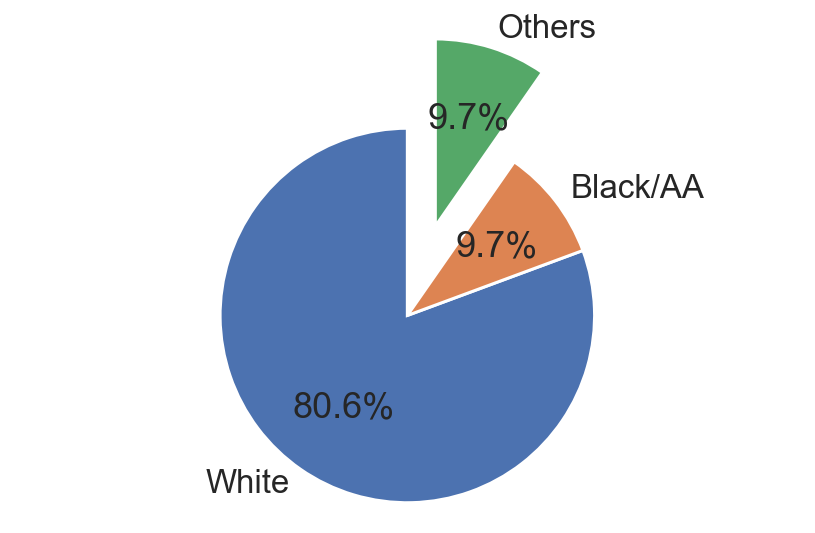

In [102]:
raw_data = {'Race': ['White', 'Black/AA', 'Others'],
            'Numbers': [25, 3, 3]}
pie = pd.DataFrame(raw_data)
pieChart(pie, 0.5, explode=True, shadow = False)
#plt.savefig('postmatch_N_Race.svg') 

_RCC_

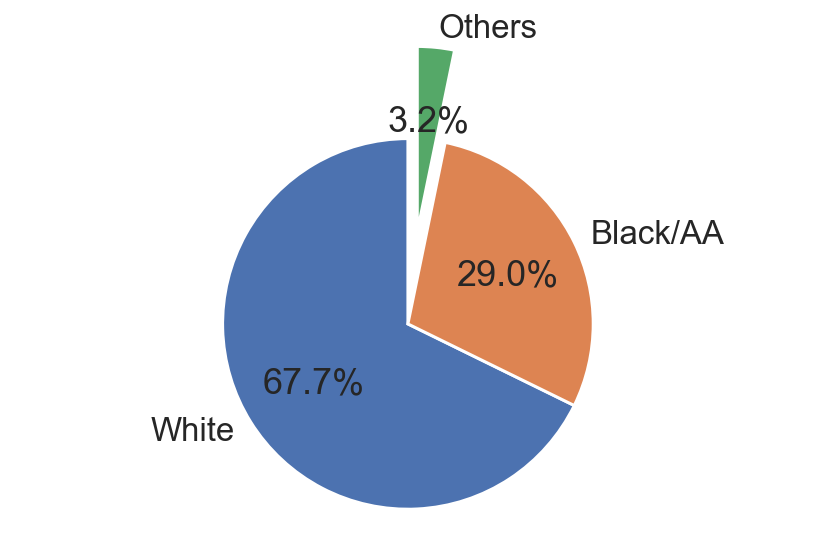

In [103]:
raw_data = {'Race': ['White', 'Black/AA', 'Others'],
            'Numbers': [21, 9, 1]}
pie = pd.DataFrame(raw_data)
pieChart(pie, 0.5, explode=True, shadow = False)
#plt.savefig('postmatch_C_Race.svg') 

In [104]:
modelcohort = pd.merge(dfsample.to_frame(), combined, on='Patient ID') 
print (modelcohort.shape)
modelcohort.head()

(62, 7154)


,Patient ID,Sample ID,1,2,3,4,5,6,7,8,...,hypoxanthine_1,hypoxanthine_2,formate,unk10,Trigonelline_1,Trigonellinamide_1,Trigonellinamide_2,Trigonelline_2,Trigonellinamide_3,unk11
0,PD120,C061,4.050596e+08,1.360247e+09,6.470647e+06,11160.005706,16164.306798,1373.003603,848875.538167,565565.885445,...,0.010207,0.017188,0.023662,0.001285,0.009380,0.006555,0.005620,0.003677,0.005556,0.001816
1,PD124,C063,4.912670e+08,2.118876e+09,9.369729e+06,143244.919951,3949.538516,1709.855556,135339.931516,306426.297763,...,0.182630,0.035155,0.021574,0.000558,0.024728,0.012849,0.011794,0.013070,0.014443,0.000790
2,PD053,C024,2.279127e+08,1.498429e+09,1.497720e+09,11466.812948,17645.857721,3365.581813,57667.083500,134748.709741,...,0.008956,0.013887,0.025572,0.001784,0.008556,0.006887,0.006598,0.004631,0.006984,0.001298
3,PD088,C037,6.755539e+08,1.600861e+09,1.604675e+09,2773.104415,31028.537746,1765.901296,138425.977992,194029.827203,...,0.009306,0.014678,0.021373,0.001174,0.014219,0.004944,0.004489,0.010313,0.003169,0.000529
4,PD005,C003,7.656287e+08,1.673333e+09,7.473487e+06,8567.128440,25730.930023,3246.459929,133904.513302,495502.089214,...,0.008652,0.007889,0.021506,0.018444,0.193980,0.007303,0.007281,0.101210,0.007860,0.001027


Non-metabolic features in the `modelcohort` dataframe include the following: 
-  Sample ID
-  Patient ID
-  Collection
-  Gender
-  Race
-  BMI
-  Smoker
-  Age
-  Groups

### [Go back to notebook content](#0)

In [115]:
# Export model cohort
#modelcohort.to_excel('modelcohort.xlsx')

### Test Cohort

_The complement of the two dataframe_ <br>
`combined` - `modelcohort` = `testcohort`

In [116]:
# commented out, takes long to run

#testcohort = combined.merge(modelcohort, how = 'outer', indicator=True).loc[lambda x : x['_merge']=='left_only']
#testcohort['Groups'].value_counts()

Control    143
RCC         51
Name: Groups, dtype: int64

In [117]:
# Export the test Cohort
#testcohort.to_excel('testcohort.xlsx')

In [108]:
# Export the MS_Label
#MS_labels.to_excel('MS_labels.xlsx')

# End of Notebook